# 이더리움 가격 예측 모델
#### 과거데이터를이용해서 과거데이터를 예측하고 실제 과거 데이터로 검증해보는 방식

## 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# LSTM (Long Short Term Memory) 모델 사용
# 인공지능 모델 : 이전 데이터를 이용하여 이후 데이터를 예측하는 인공지능 모델
# from keras.callbacks import TensorBoard, MedelCheckpoint, ReduceLROnPlateau
import datetime

Using TensorFlow backend.


## Load Dataset (데이터 불러오기)

In [2]:
data = pd.read_csv('dataset/ethereum.csv')
data['High'].fillna(data['High'].mean(), inplace=True) # unique()값으로 조회해 본 결과 데이터 중 nan값이 있었음.
data['Low'].fillna(data['Low'].mean(), inplace=True)  
data.head(3)

,Date,Open*,High,Low,Close**,Volume,Market Cap
0,21-Mar-19,140.48,141.00,135.86,136.64,"5,087,247,796","14,392,427,839"
1,22-Mar-19,136.56,138.79,136.23,137.18,"4,490,899,266","14,451,740,115"
2,23-Mar-19,137.04,139.39,136.91,138.24,"4,436,568,613","14,565,143,357"


## Compute Mid Price (중간 가격 계산)

In [3]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices)/2 #중간가격 저장

## Create Windows(윈도우 생성)

In [4]:
seq_len = 50 # 최근 50일간의 데이터를 파악하여 미래가격 예측, 50이라는 것이 window 사이즈 (변경 가능)
sequence_length = seq_len + 1 # 50개의 데이터를 보고 51번째를 예측하기 위해 + 1 설정, 한칸씩 밀리면서 윈도우를 만들어간다.

result = []
for i in range(len(mid_prices) - sequence_length): # for문을 통해 \
    result.append(mid_prices[i:i+sequence_length]) # 51개씩 단계별로 윈도우를 result 에 저장

## Normalize Data (정규화)

In [5]:
normalized_data = []
for window in result: #정규화 작업 : 예측률을 높이기 위해 한다.
    normalized_window = [((float(p) / float(window[0]))-1)for p in window] # 윈도우를 모두 모두 읽으며 윈도우를 정규화한다.
                            # 첫 번째에서 자기 자신을 자기로 나누고 -1을 해서 0으로 만든다.
                            # 다음날 데이터에서 전날 데이터를 나눈것 에서 -1 해서 비율을 모두 반복계산하여 정규화
    normalized_data.append(normalized_window)    # 정규화 데이터에 저장
    
result = np.array(normalized_data)

# 트레이닝 데이터와 테스트 데이터를 나눈다.
row = int(round(result.shape[0]*0.9)) # 90% 를 트레이닝 셋으로 나눈다.
train = result[:row,:]         # 트레이닝 셋으로 나뉜 결과를 저장
np.random.shuffle(train)       # 트레이닝 셋을 random으로 섞어서 해주는게 좋다.(순서대로하면 익숙해질 수 있음)

x_train = train[:,:-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
y_train = train[:,-1]

x_test = result[row:,:-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = result[row:,-1]

x_train.shape, x_test.shape
# ((1059, 50, 1), (118, 50, 1)) --> 1059일의 데이터를 기반으로 118일의 주식 가격을 예측할 것이다.

((284, 50, 1), (31, 50, 1))

## Build a Model(모델생성)

In [6]:
model = Sequential() # keras.models.Sequential() : 모델을 순차적으로 정의하는 클래스

#keras.layers.LSTM() : LSTM 레이어
#LSTM 이라는 모듈이 존재, input은 50개
model.add(LSTM(50, return_sequences=True, input_shape=(50,1))) # 1st LSTM유닛 수 : 50개(숫자 조정 가능 -> 조정해가며 성능 테스트 가능)

model.add(LSTM(64, return_sequences=False))  # 2nd LSTM유닛 수 : 64개(숫자 조정 가능 -> 조정해가며 성능 테스트 가능)

#keras.layers.Dense() : Fully connected layer
model.add(Dense(1, activation='linear')) # 하루의 데이터를 예측할 것 이기 때문에 1 작성, 작동방법은 선형계획법

#mse : Mean Squared Error
model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


## Traning(학습)

In [7]:
model.fit(x_train, y_train,                 # 학습을 시키기 위해 fit 메소드 사용(트레이닝셋을 넣어줌)
         validation_data=(x_test, y_test),  # 검증 데이터에 테스트 데이터를 넣어준다.
         batch_size=10,                     # 한 번에 몇 개씩 묶어서 학습시킬건지 지정
         epochs=20)                         # 20번동안 반복학습을 시킨다.
#실행 시 loss 가 발생하게 되는데, loss가 발생될수록 학습이 잘 되고 있다는 증거가 된다.
# validation loss의 값이 작을수록 학습이 잘 된 것

Train on 284 samples, validate on 31 samples
Epoch 1/20
284/284 [==============================] - 1s 5ms/step - loss: 0.0222 - val_loss: 0.1359
Epoch 2/20
284/284 [==============================] - 1s 3ms/step - loss: 0.0111 - val_loss: 0.0493
Epoch 3/20
284/284 [==============================] - 1s 3ms/step - loss: 0.0102 - val_loss: 0.0582
Epoch 4/20
284/284 [==============================] - 1s 3ms/step - loss: 0.0076 - val_loss: 0.0333
Epoch 5/20
284/284 [==============================] - 1s 3ms/step - loss: 0.0067 - val_loss: 0.0424
Epoch 6/20
284/284 [==============================] - 1s 3ms/step - loss: 0.0058 - val_loss: 0.0311
Epoch 7/20
284/284 [==============================] - 1s 3ms/step - loss: 0.0063 - val_loss: 0.0231
Epoch 8/20
284/284 [==============================] - 1s 3ms/step - loss: 0.0049 - val_loss: 0.0212
Epoch 9/20
284/284 [==============================] - 1s 3ms/step - loss: 0.0054 - val_loss: 0.0219
Epoch 10/20
284/284 [==============================] - 

## Prediction(예측)

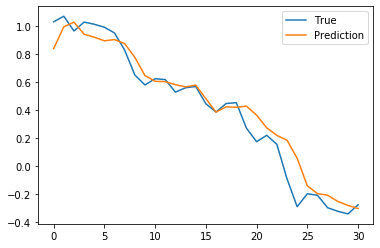

In [8]:
# 모델이 잘 학습되었는지 검증하고 그래프 작성
pred = model.predict(x_test) # model.predict() : 모델을 사용하여 예측, 예측한 결과값을 pred에 저장

fig = plt.figure(facecolor = 'white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()